In [1]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
import ccxt

In [2]:
# Connecting to Binance and Fetching 5 min OHLCV
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '5m'
limit = 1000  # max 1500 per request
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

# Convert to DataFrame
df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Timestamp', inplace=True)

# Calculating RSI 
rsi = RSIIndicator(close=df["Close"], window=14)
df["RSI"] = rsi.rsi()

# preview the result
print(df[["Close", "RSI"]].tail(10))

                         Close        RSI
Timestamp                                
2025-08-03 11:55:00  113862.18  47.292392
2025-08-03 12:00:00  113846.18  46.232629
2025-08-03 12:05:00  113792.64  42.778150
2025-08-03 12:10:00  113742.75  39.794315
2025-08-03 12:15:00  113688.14  36.770883
2025-08-03 12:20:00  113746.00  41.814957
2025-08-03 12:25:00  113788.00  45.230492
2025-08-03 12:30:00  113812.84  47.204423
2025-08-03 12:35:00  113836.93  49.119619
2025-08-03 12:40:00  113836.93  49.119619


In [3]:
# Step 4: Building an RSI Strat x >70 sell, x < 30buy Simple
## This must include the log and simulates trade 
in_position = False  # Track if I'm currently in a trade
trades = []          # Store all completed trades

for i in range(1, len(df)):
    rsi = df["RSI"].iloc[i]
    price = df["Close"].iloc[i]
    time = df.index[i]

    if not in_position and rsi < 30:
        # Buy signal
        entry_price = price
        entry_time = time
        in_position = True

    elif in_position and rsi > 70:
        # Sell signal
        exit_price = price
        exit_time = time
        pnl = (exit_price - entry_price) / entry_price  # % gain/loss
        trades.append({
            "Entry Time": entry_time,
            "Exit Time": exit_time,
            "Entry Price": entry_price,
            "Exit Price": exit_price,
            "PnL %": pnl * 100
        })
        in_position = False


In [4]:
trades_df = pd.DataFrame(trades)
print(trades_df)

           Entry Time           Exit Time  Entry Price  Exit Price     PnL %
0 2025-07-31 13:30:00 2025-08-01 12:40:00    117851.01   115882.18 -1.670609
1 2025-08-01 13:45:00 2025-08-02 04:30:00    114484.37   114050.01 -0.379406
2 2025-08-02 06:20:00 2025-08-03 03:35:00    113612.66   113630.61  0.015799


In [5]:
df["Returns"] = df["Close"].pct_change()
df["Position"] = 0

for i in range(len(trades)):
    entry = trades[i]["Entry Time"]
    exit = trades[i]["Exit Time"]
    df.loc[entry:exit, "Position"] = 1

df["Strategy_Returns"] = df["Returns"] * df["Position"]

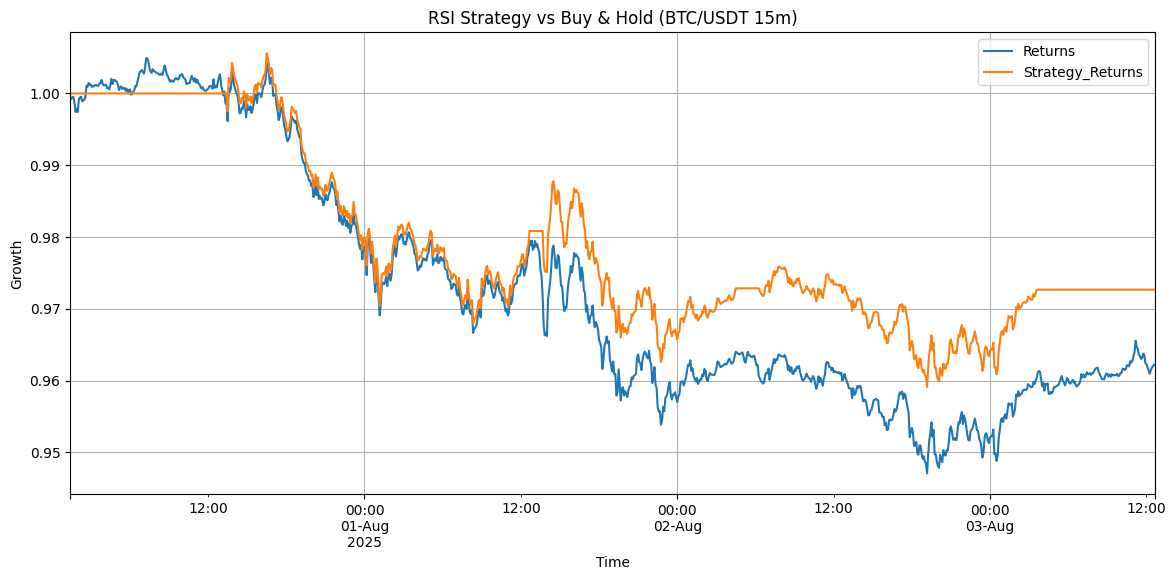

In [6]:
(1 + df[["Returns", "Strategy_Returns"]]).cumprod().plot(figsize=(14, 6))
plt.title("RSI Strategy vs Buy & Hold (BTC/USDT 15m)")
plt.xlabel("Time")
plt.ylabel("Growth")
plt.grid()
plt.show()

In [7]:
# Convert PnL % to growth factor (e.g., 2.5% → 1.025)
trades_df["Growth"] = 1 + (trades_df["PnL %"] / 100)

# Calculate cumulative equity growth
trades_df["Equity Curve"] = trades_df["Growth"].cumprod()

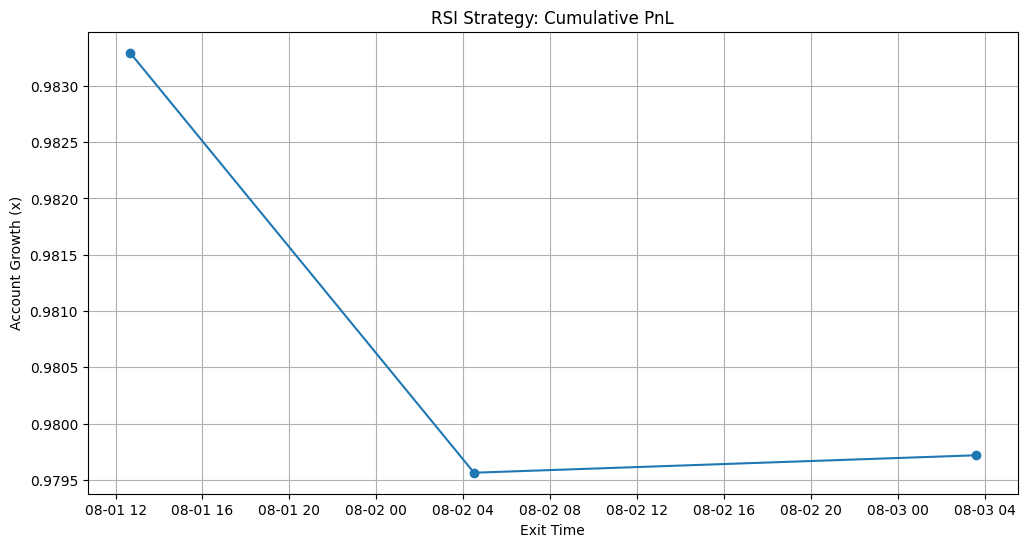

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(trades_df["Exit Time"], trades_df["Equity Curve"], marker='o')
plt.title("RSI Strategy: Cumulative PnL")
plt.xlabel("Exit Time")
plt.ylabel("Account Growth (x)")
plt.grid(True)
plt.show()